# Minerva: AI Guardian for Scam Protection

This notebook implements a multi-agent system for analyzing images (screenshots) to identify scam attempts, and provide personalized scam prevention. It uses [AutoGen](https://github.com/microsoft/autogen/) to orchestrate various specialized agents that work together.

Benefits:
- Automates the process of identifying suspicious scam patterns.
- Prevents Financial Loss
- Saves Time: Early scam detection reduces the number of claims filed by end-users.

## Install Dependencies

In [1]:
%pip install -q autogen-agentchat~=0.2 pillow pytesseract pyyaml

Note: you may need to restart the kernel to use updated packages.


In [2]:
import autogen

from IPython.display import Image as IPImage
from IPython.display import display

flaml.automl is not available. Please install flaml[automl] to enable AutoML functionalities.


In [17]:
import os
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

config_list = [
    {
        "model": "gpt-4o-mini",
        "api_key": os.getenv("OPENAI_API_KEY")
    }
]

llm_config = {
    "config_list": config_list,
    "timeout": 120,
}

In [18]:
import yaml

with open('config/agents.yaml', 'r') as file:
    config = yaml.safe_load(file)

## Agents Creation

In [19]:
from tools import Tools

def create_agents():
    tools = Tools()

    ocr_agent = autogen.AssistantAgent(
        name="OCR_Specialist",
        description="Extracts text from an image",
        system_message=config['ocr_agent']['assignment'],
        llm_config=llm_config
    )

    url_agent = autogen.AssistantAgent(
        name="URL_Agent",
        description="Checks if a URL is safe",
        system_message=config['url_agent']['assignment'],
        llm_config=llm_config
    )
   
    content_agent = autogen.AssistantAgent(
        name="Content_Analyst",
        description="Analyzes the text for scam patterns",
        system_message=config['content_agent']['assignment'],
        llm_config=llm_config
    )

    decision_agent = autogen.AssistantAgent(
        name="Decision_Maker",
        description="Synthesizes the analyses and make final determination",
        system_message=config['decision_agent']['assignment'],
        llm_config=llm_config
    )

    summary_agent = autogen.AssistantAgent(
        name="Summary_Agent",
        description="Generate a summary of the final determination",
        system_message=config['summary_agent']['assignment'],
        llm_config=llm_config
    )

    user_proxy = autogen.UserProxyAgent(
        name="user_proxy",
        is_termination_msg=lambda x: "COMPLETE" in x.get("content", ""),
        #is_termination_msg=lambda x: x.get("content", "") and x.get("content", "").rstrip().endswith("TERMINATE"),
        human_input_mode="NEVER",
        max_consecutive_auto_reply=10,
    )

    @user_proxy.register_for_execution()
    @ocr_agent.register_for_llm(description="Extracts text from an image path")
    def ocr(image_path: str) -> str:
        return tools.ocr(image_path)
        
    @user_proxy.register_for_execution()
    @content_agent.register_for_llm(description="Checks if a URL is safe")
    def url_checker (url: str) -> str:
        return tools.is_url_safe(url)


    #return ocr_agent, url_agent, content_agent, decision_agent, summary_agent, user_proxy
    return ocr_agent, content_agent, decision_agent, summary_agent, user_proxy

## Workflow

In [21]:
class ScamDetectionWorkflow:
    def __init__(self):
        #self.ocr_agent, self.url_agent, self.content_agent, self.decision_agent, self.summary_agent, self.user_proxy = create_agents()
        self.ocr_agent, self.content_agent, self.decision_agent, self.summary_agent, self.user_proxy = create_agents()
        
    def analyze(self, image_path):
        """Coordinate the multi-agent analysis.
        """
        
        groupchat = autogen.GroupChat(
            #agents=[self.ocr_agent, self.url_agent, self.content_agent, self.decision_agent, self.summary_agent, self.user_proxy],
            agents=[self.ocr_agent, self.content_agent, self.decision_agent, self.summary_agent, self.user_proxy],
            messages=[],
            max_round=15,
            #speaker_selection_method="round_robin",
        )
        manager = autogen.GroupChatManager(groupchat=groupchat, llm_config=llm_config)

        # 2. URL Agent: Check if a URL is safe
        #messages = self.user_proxy.initiate_chat(
        #    manager,
        #    message=f"""
        #    1. OCR Agent: Extract text from this image: {image_path}
        #    2. Content Agent: Evaluate the messaging and claims
        #    3. Decision Maker: Synthesize all analyses and make final determination
        #    4. Summarize the findings""",
        #)
        messages = self.user_proxy.initiate_chat(
            manager,
            message=f"""does the content of the image in {image_path} represent a scam?""",
        )

        return messages

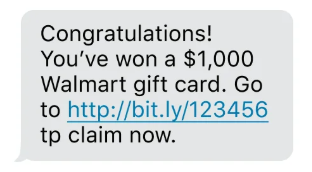

In [22]:
image_path = "./samples/02.giftcard.message.scam.png"
#image_path = "./samples/74.customer.service.twitter.scam.png"
#image_path = "./samples/42.amazon.email.scam.png"
#image_path = "./samples/22.giveaway.email.scam.png"
#image_path = "./samples/32.multifactor.email.scam.png"
#image_path = "./samples/39.paypal.email.scam.png"
display(IPImage(filename=image_path))

In [23]:
workflow = ScamDetectionWorkflow()
results = workflow.analyze(image_path)

user_proxy (to chat_manager):

does the content of the image in ./samples/02.giftcard.message.scam.png represent a scam?

--------------------------------------------------------------------------------



Next speaker: OCR_Specialist

OCR_Specialist (to chat_manager):

***** Suggested tool call (call_CRjjATgsjHAUQECgDKBauJNe): ocr *****
Arguments: 
{"image_path":"./samples/02.giftcard.message.scam.png"}
********************************************************************

--------------------------------------------------------------------------------

Next speaker: user_proxy


>>>>>>>> EXECUTING FUNCTION ocr...
user_proxy (to chat_manager):

user_proxy (to chat_manager):

***** Response from calling tool (call_CRjjATgsjHAUQECgDKBauJNe) *****
Congratulations!
You've won a $1,000
Walmart gift card. Go

http://bit.ly/123456
tp claim now.

**********************************************************************

--------------------------------------------------------------------------------

Next speaker: Content_Analyst

Content_Analyst (to chat_manager):

***** Suggested tool call (call_68tUF9q6PDAu3QtPpPFp0dBr): url_checker *****
Arguments: 
{"url": "http://bit.ly/123456"}
***********

In [10]:
import pprint

pprint.pprint(results.chat_history[-1])

{'content': 'The message claiming "You\'ve won a $1,000 Walmart gift card" '
            'raises several red flags indicating a high probability of being a '
            'scam. It notifies the recipient about an unsolicited prize, '
            'creates urgency by urging immediate action, and includes a '
            'shortened link (bit.ly) that obscures its real destination and '
            'often indicates a potential threat. Users should avoid clicking '
            'on such links and be skeptical of unsolicited prize '
            'notifications. **Actionable recommendation:** Do not engage with '
            'or follow links in unsolicited messages and report suspicious '
            'communications. \n'
            '\n'
            'COMPLETE',
 'name': 'Summary_Agent',
 'role': 'user'}


In [11]:
import json


with open('results.json', 'w') as json_file:
    json.dump(results.__dict__, json_file, indent=4)

In [23]:
results.summary

'This analysis confirms that the message claiming you won a $1,000 Walmart gift card is a high-probability scam. Key indicators include the use of congratulatory language for a prize you did not enter to win, a suspicious shortened URL (http://bit.ly/123456), and high-pressure tactics urging immediate action. Legitimate communications from companies like Walmart typically do not come unsolicited, meaning this message lacks context and authenticity. **Recommendation:** Do not click any links or provide personal information in response to such messages. Remain cautious and report any suspicious communications. \n\nANALYSIS_COMPLETE'